In [2]:
import plot
from shap.maskers import Independent
from sklearn.utils import resample, shuffle
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [3]:
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('predictions.pickle', 'rb') as f:
    X, display_data, feature_names, n_features, n_samples, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b = pickle.load(f)

# Sample
X, display_data, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b = \
    shuffle(X, display_data, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b, random_state=42, n_samples=500)
n_samples = X.shape[0]
indices = np.array(range(n_samples))

In [4]:
try:
    with open(f'shapvalues.soa.log_odds.pickle', 'rb') as f:
        shap_values_a, shap_values_b, shap_values_a_vs_b, is_finite, is_outlier, is_normal, feature_order = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

Loaded cached shap values


## Generate Explanations

Now we define the functions to be explained:

In [5]:
proba_to_log_proba = lambda proba: np.log(proba)
log_proba_to_log_odds = lambda log_proba: log_proba[:, 1] - log_proba[:, 0]
predict_log_odds_a = lambda X: log_proba_to_log_odds(clf_a.predict_log_proba(X))
predict_log_odds_b = lambda X: log_proba_to_log_odds(proba_to_log_proba(clf_b.predict_proba(X)))

And now we calculate SHAP values for each function:

In [6]:
%%time

background_data = X
def explain(predict):
    masker = Independent(data=background_data, max_samples=100)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X)
    shap_values.display_data = display_data
    return shap_values

shap_values_a = explain(predict_log_odds_a)
shap_values_b = explain(predict_log_odds_b)

shap_values_a_vs_b = shap_values_b - shap_values_a
shap_values_a_vs_b.data = shap_values_a.data
shap_values_a_vs_b.display_data = shap_values_a.display_data

is_finite = np.all(np.isfinite(shap_values_a.values), axis=1) & np.all(np.isfinite(shap_values_b.values), axis=1)
is_outlier = np.any(shap_values_a.abs.values > 8, axis=1) | np.any(shap_values_b.abs.values > 8, axis=1)
is_normal = is_finite & ~is_outlier
feature_order = np.flip(shap_values_a_vs_b[is_normal].abs.mean(axis=0).values.argsort())

with open(f'shapvalues.soa.log_odds.pickle', 'wb') as f:
    pickle.dump((shap_values_a, shap_values_b, shap_values_a_vs_b, is_finite, is_outlier, is_normal, feature_order), f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 501it [00:21, 14.05it/s]                         
Permutation explainer: 501it [00:25, 12.19it/s]                         


CPU times: user 1min 6s, sys: 6.1 s, total: 1min 12s
Wall time: 47.5 s


## Analyze

In [7]:
print(f'non-finite SHAP-values: {np.sum(~is_finite)}')
print(f'outlier SHAP-values: {np.sum(is_outlier)}')
print(f'total SHAP-values: {len(is_normal)}')

non-finite SHAP-values: 0
outlier SHAP-values: 4
total SHAP-values: 500


### Feature Importance

We estimate it with the mean absolute SHAP value (which is the default for this plot) and will also sort features subsequently in this order

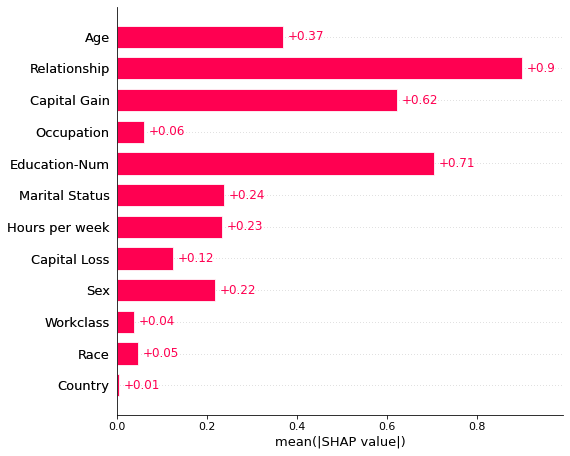

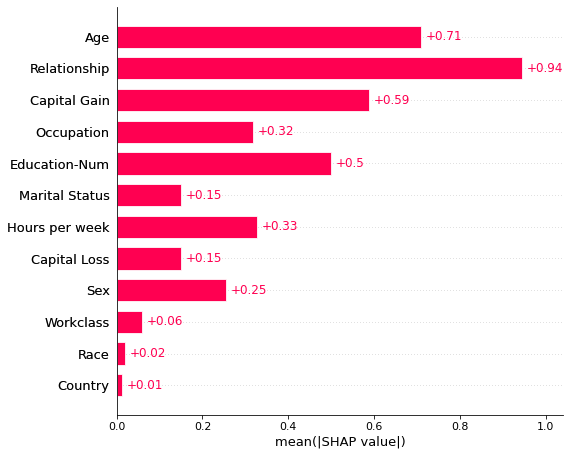

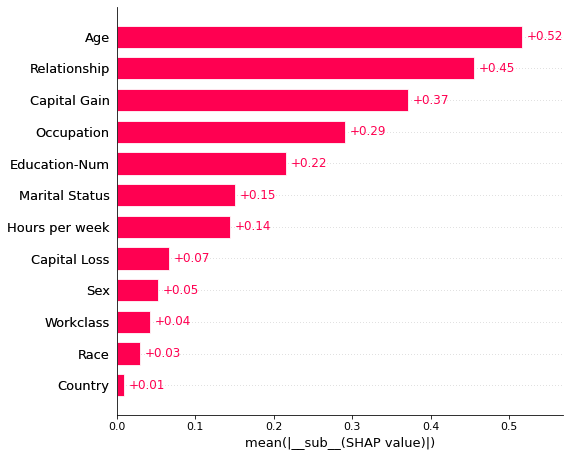

In [8]:
shap.plots.bar(shap_values_a[is_normal], order=feature_order, max_display=n_features)
shap.plots.bar(shap_values_b[is_normal], order=feature_order, max_display=n_features)
shap.plots.bar(shap_values_a_vs_b[is_normal], order=feature_order, max_display=n_features)

### SHAP Value Distribution

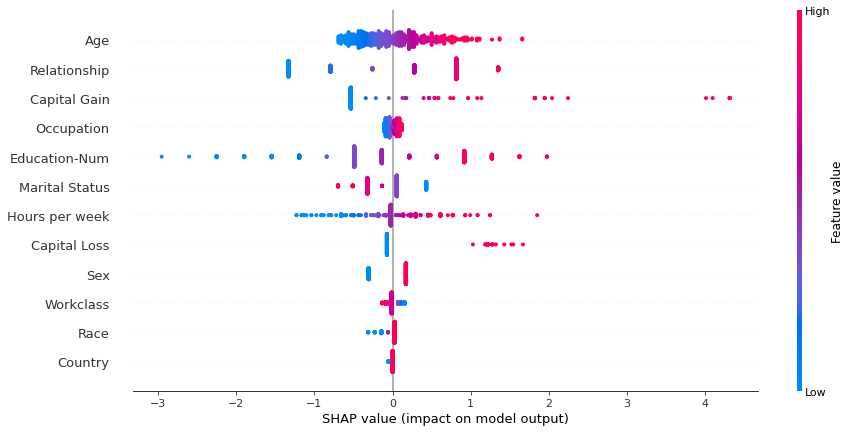

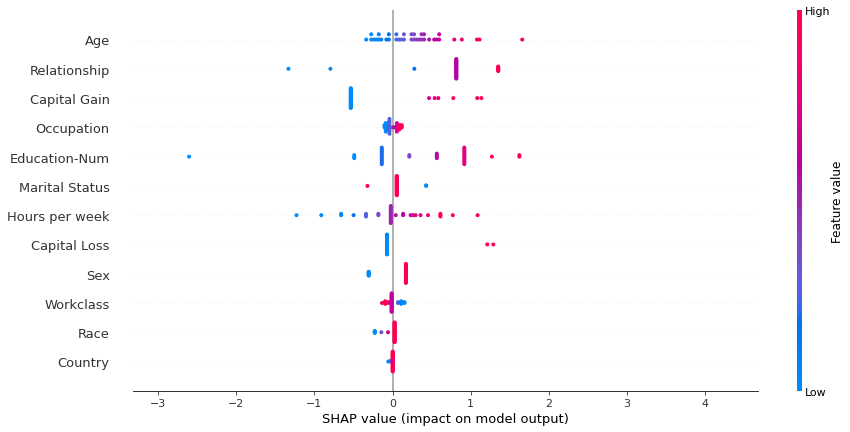

In [9]:
shap.plots.beeswarm(shap_values_a[is_normal], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
xlim = plt.xlim()
plt.show()
shap.plots.beeswarm(shap_values_a[is_normal & (pred_a != pred_b)], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
plt.xlim(xlim)
plt.show()

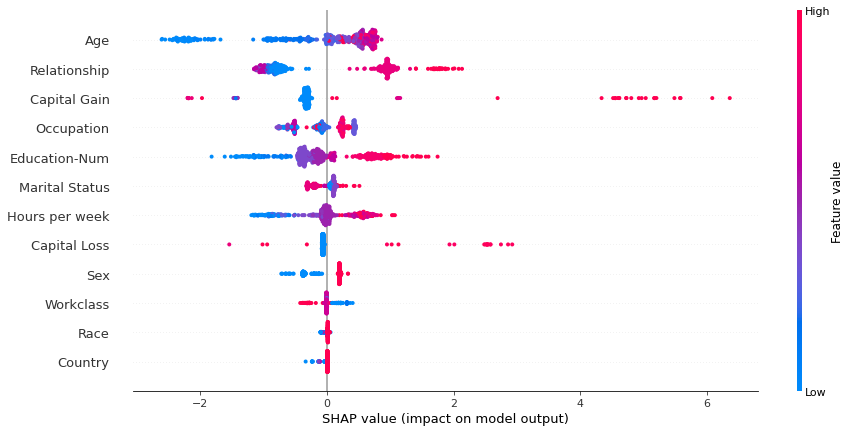

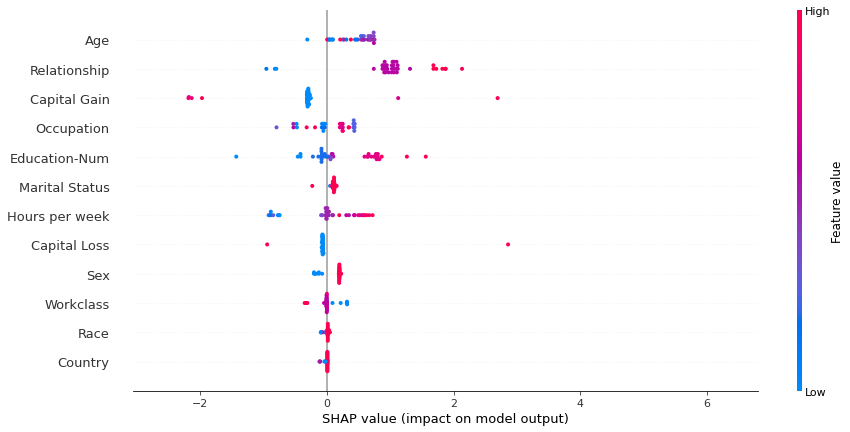

In [10]:
shap.plots.beeswarm(shap_values_b[is_normal], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
xlim = plt.xlim()
plt.show()
shap.plots.beeswarm(shap_values_b[is_normal & (pred_a != pred_b)], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
plt.xlim(xlim)
plt.show()

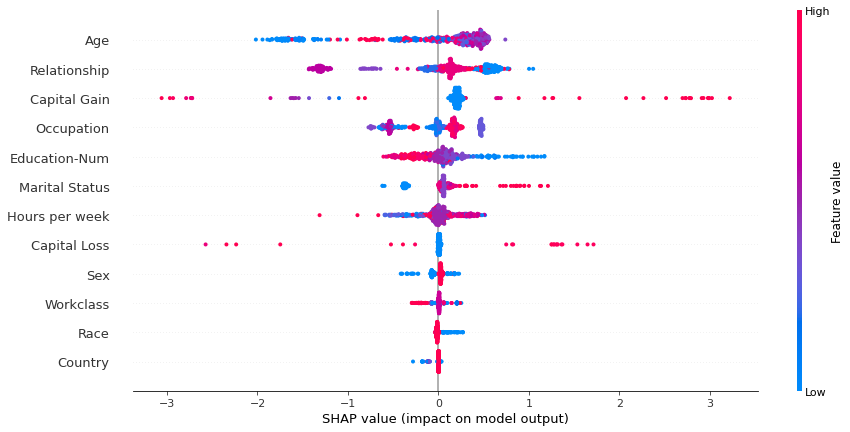

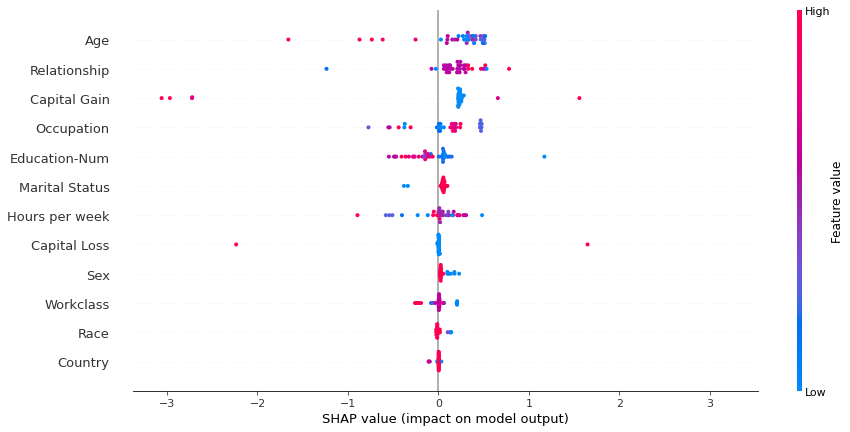

In [11]:
shap.plots.beeswarm(shap_values_a_vs_b[is_normal], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
xlim = plt.xlim()
plt.show()
shap.plots.beeswarm(shap_values_a_vs_b[is_normal & (pred_a != pred_b)], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
plt.xlim(xlim)
plt.show()

### Features' Partial Dependence Plots

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


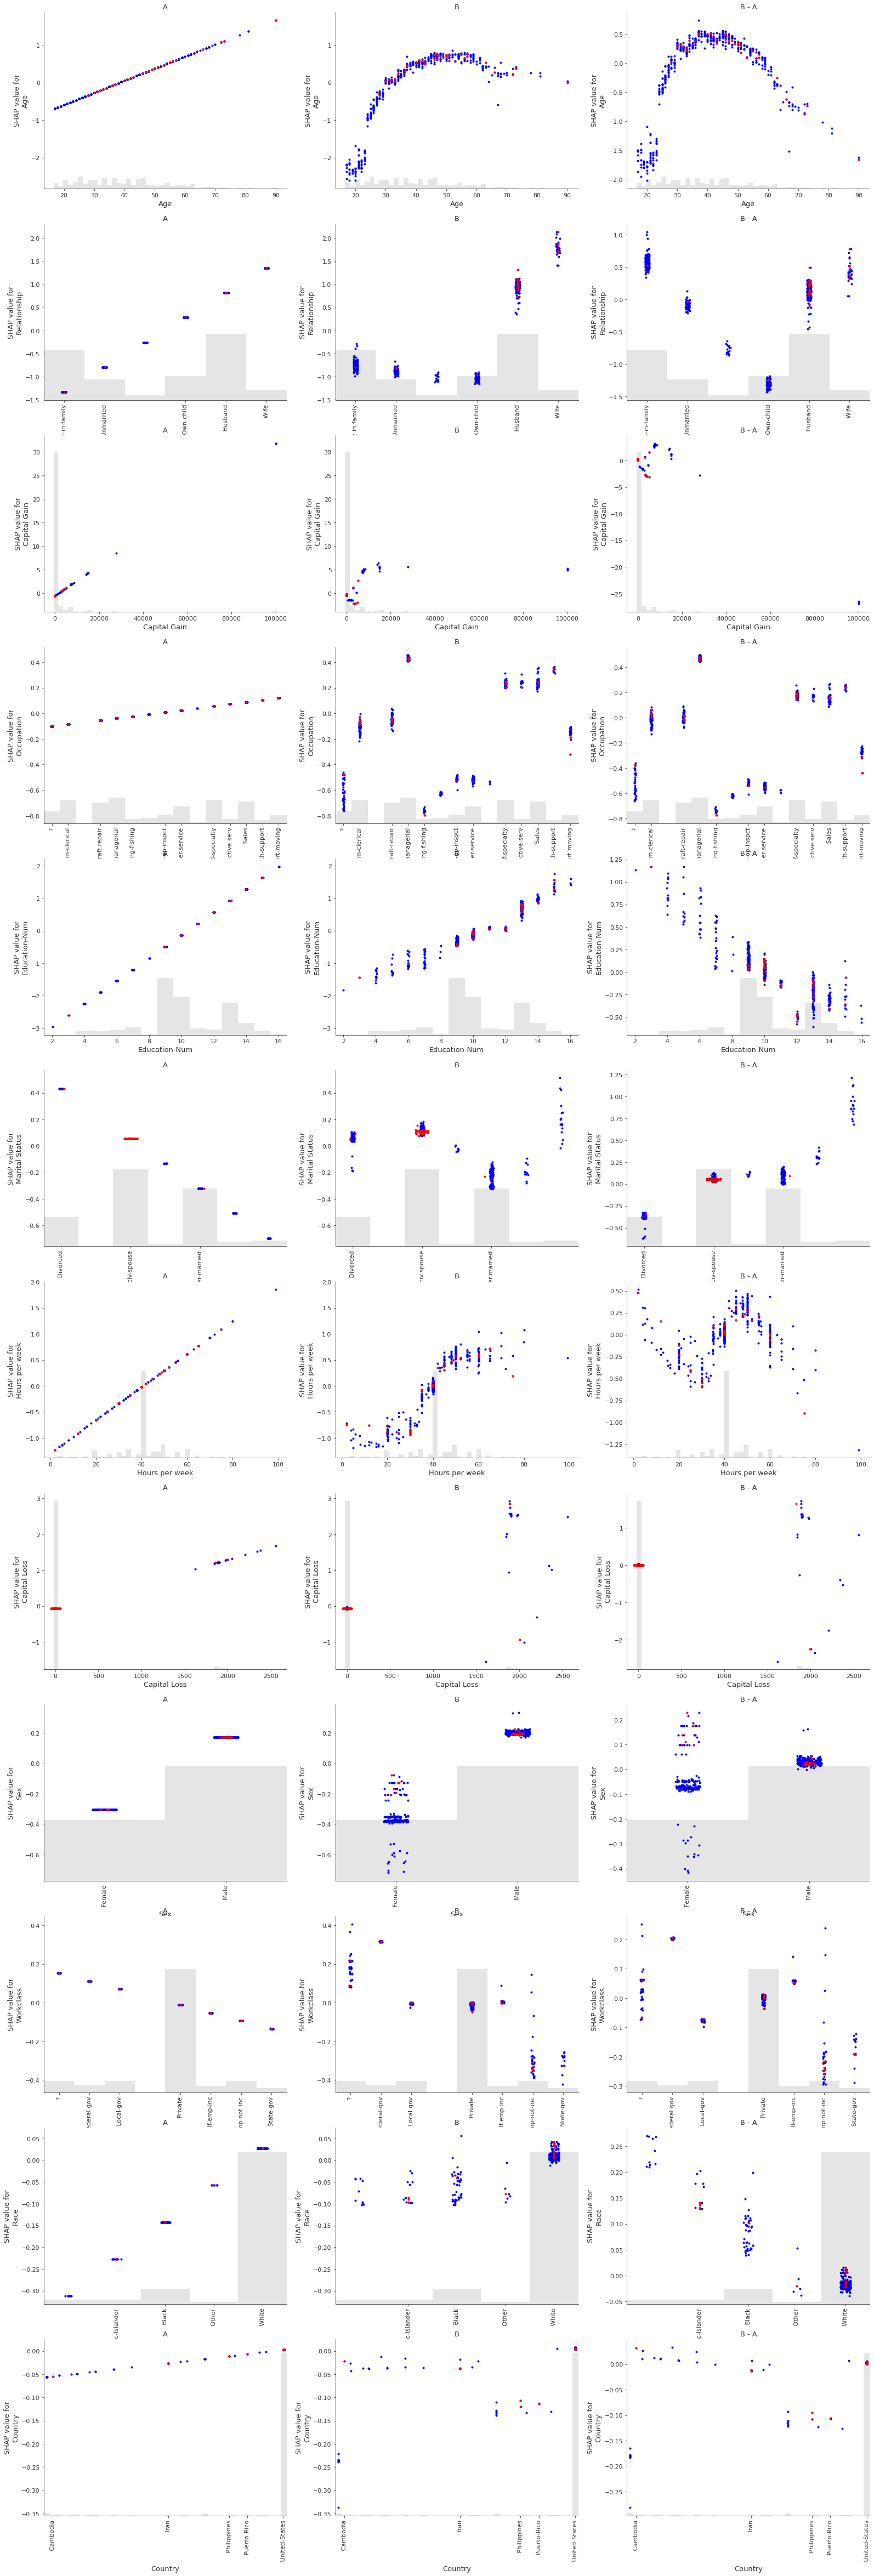

In [12]:
n_columns = 3
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names[feature_order]:
    ax1 = fig.add_subplot(n_rows, n_columns, i)
    ax2 = fig.add_subplot(n_rows, n_columns, i+1, sharey=ax1)
    ax3 = fig.add_subplot(n_rows, n_columns, i+2, sharey=None)
    shap.plots.scatter(shap_values_a[:, feature], title='A', ax=ax1, color='blue', show=False)
    shap.plots.scatter(shap_values_a[pred_a != pred_b, feature], title='A', ax=ax1, color='red', hist=False, show=False)
    shap.plots.scatter(shap_values_b[:, feature], title='B', ax=ax2, color='blue', show=False)
    shap.plots.scatter(shap_values_b[pred_a != pred_b, feature], title='B', ax=ax2, color='red', hist=False, show=False)
    shap.plots.scatter(shap_values_a_vs_b[:, feature], title='B - A', ax=ax3, color='blue', show=False)
    shap.plots.scatter(shap_values_a_vs_b[pred_a != pred_b, feature], title='B - A', ax=ax3, color='red', hist=False, show=False)
    i += n_columns
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [13]:
mask = is_normal & (pred_a != pred_b)
order = plot.shap_force(shap_values_a_vs_b[mask], 'A vs. B')
plot.shap_force(shap_values_a[mask], 'A', ordering=order)
plot.shap_force(shap_values_b[mask], 'B', ordering=order);

In [14]:
idx_pred_eq = resample(indices[is_normal & (pred_a == pred_b)], n_samples=100, replace=False, random_state=2)
order = plot.shap_force(shap_values_a_vs_b[idx_pred_eq], 'A vs. B')
plot.shap_force(shap_values_a[idx_pred_eq], 'A', ordering=order)
plot.shap_force(shap_values_b[idx_pred_eq], 'B', ordering=order);

### Hierarchically Clustered SHAP Values

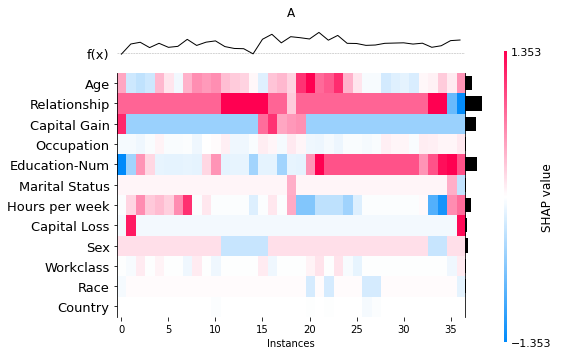

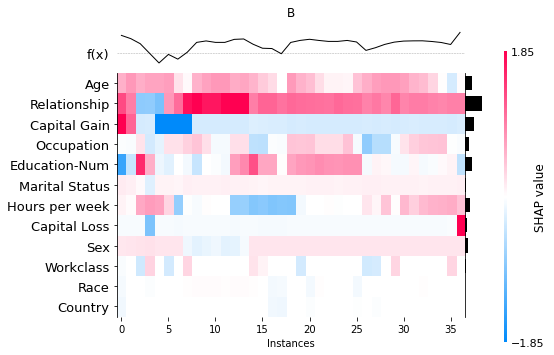

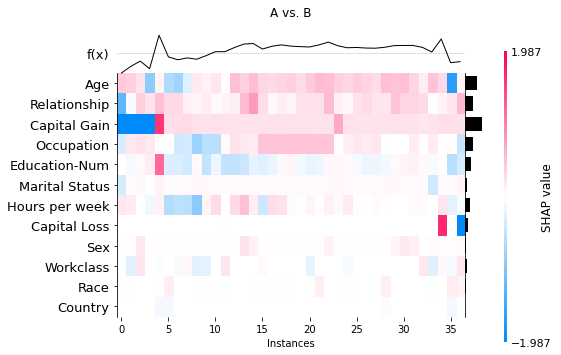

In [15]:
mask = is_normal & (pred_a != pred_b)
plot.shap_heatmap(shap_values_a[mask], 'A', feature_order)
plot.shap_heatmap(shap_values_b[mask], 'B', feature_order)
plot.shap_heatmap(shap_values_a_vs_b[mask], 'A vs. B', feature_order)

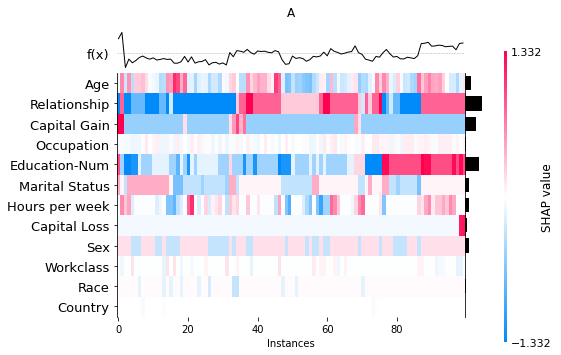

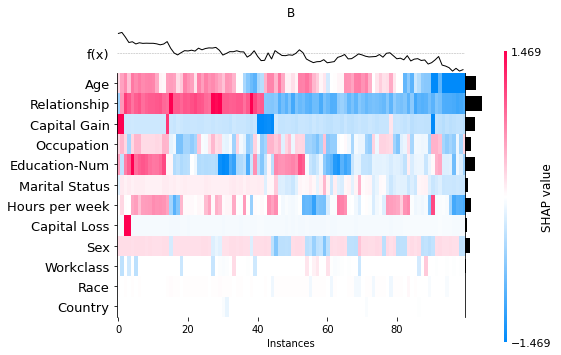

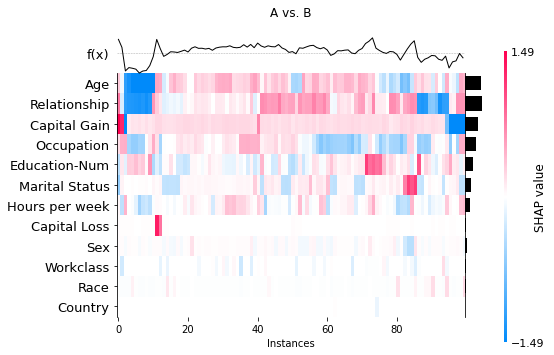

In [16]:
mask = is_normal & (pred_a == pred_b)
shap_values_a_subset, shap_values_b_subset, shap_values_a_vs_b_subset = \
    shuffle(shap_values_a[mask], shap_values_b[mask], shap_values_a_vs_b[mask], random_state=0, n_samples=100)
plot.shap_heatmap(shap_values_a_subset, 'A', feature_order)
plot.shap_heatmap(shap_values_b_subset, 'B', feature_order)
plot.shap_heatmap(shap_values_a_vs_b_subset, 'A vs. B', feature_order)

### Unusual instances

#### Outliers in SHAP-values

An unusually high capital gain leads to a very big SHAP value for the instance's feature.

In [17]:
idx_outliers = np.where(is_outlier & is_finite)[0]

In [18]:
pd.DataFrame(display_data[idx_outliers, :], index=idx_outliers, columns=feature_names)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
42,48.0,Private,15.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999.0,0.0,50.0,United-States
280,45.0,Private,10.0,Divorced,Craft-repair,Not-in-family,White,Male,27828.0,0.0,56.0,United-States
282,26.0,Private,15.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,60.0,United-States
482,46.0,Private,15.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,60.0,United-States


In [19]:
for idx in shuffle(idx_outliers, n_samples=3):
    plot.shap_force(shap_values_a[idx], f'A (#{idx})')
    plot.shap_force(shap_values_b[idx], f'B (#{idx})')

#### Non-finite SHAP-values

In [20]:
idx_nonfinite = np.where(~is_finite)[0]

In [21]:
pd.DataFrame(display_data[idx_nonfinite, :], index=idx_nonfinite, columns=feature_names)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country


In [22]:
pd.DataFrame(shap_values_a[idx_nonfinite].values, index=idx_nonfinite, columns=feature_names)

ValueError: Empty data passed with indices specified.

In [ ]:
pd.DataFrame(shap_values_b[idx_nonfinite].values, index=idx_nonfinite, columns=feature_names)